In [1]:
# Common Libraries
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import os, sys
import json
import torch
import argparse
import gc
import time
import glob
import random
import ssl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.table import Table, Column

# Detectron setup
import detectron2.utils.comm as comm
from detectron2.utils.logger import setup_logger
setup_logger() # Setup detectron2 logger
from detectron2.config import LazyConfig, get_cfg
from detectron2.engine import launch
# for evaluating model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import deepdisc.astrodet.astrodet as toolkit
import detectron2.data as d2data
# for getting precision and recall
from detectron2 import structures
from detectron2.structures import BoxMode

# deepdisc imports
from deepdisc.data_format.image_readers import RomanImageReader
from deepdisc.data_format.register_data import register_data_set
from deepdisc.inference.predictors import return_predictor_transformer, get_predictions

# Utils to analyze model
from plot_eval_utils import plot_losses, plot_det_gt, evaluate_model, plot_ap, get_pr

/home/yse2/.conda/envs/deepdisc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# needed to handle the WCS because we have upsampled annotations that we need to scale down for the WCS since the 
# WCS hasn't been scaled for the upsampled image and exists only for the small LSST img
def get_scale_factors(orig_height, orig_width):
    scale_x = orig_width / 512 
    scale_y = orig_height / 512
    return scale_x, scale_y

def adjust_coordinates(x, y, scale_x, scale_y):
    return x * scale_x, y * scale_y  # scaling down

def img_key_mapper(dataset_dict):
    """Map image keys from dataset dictionary.

    Args:
        dataset_dict (dict): Dataset dictionary containing file information

    Returns:
        str: File name from the dictionary
    """
    return dataset_dict["file_name"]

class ModelEvaluator:
    def __init__(self, run_dir, output_dir, test_data_file, cfg_file):
        """Initialize the ModelEvaluator.
        Args:
            run_dir (str): Directory containing model checkpoints
            output_dir (str): Directory for evaluation outputs
            test_data_file (str): Path to test data JSON file
            cfg_file (str): Path to model config file
        """
        self.run_dir = run_dir
        self.output_dir = output_dir
        self.test_data_file = test_data_file
        self.cfg_file = cfg_file
        self.imreader = RomanImageReader()
        
        # default params
        self.topk_per_img = 2000
        self.score_thresh = 0.3
        self.nms_thresh = 0.4
        
        self.cfg = None
        self.predictor = None
        self.test_data = None
        self.registered_test_data = None
        


    def set_thresholds(self, topk=None, score=None, nms=None):
        """Set detection thresholds.
        
        Args (Defaults set in instantiation):
            topk (int): Top-k predictions per image. 
            score (float): Score threshold
            nms (float): NMS threshold
        """
        if topk is not None:
            self.topk_per_img = topk
        if score is not None:
            self.score_thresh = score
        if nms is not None:
            self.nms_thresh = nms

    def load_model(self):
        """Load model configuration and checkpoint."""
        # finding model checkpoint
        pth_files = glob.glob(os.path.join(self.run_dir, '*.pth'))
        model_path = None
        for pth in pth_files:
            if "instances" not in pth:
                model_path = pth
                break
                
        if not model_path:
            raise ValueError(f"No valid checkpoint file found in {self.run_dir}")
            
        print(f"Using checkpoint file: {model_path}")
        
        # loading config
        print(f"\nLoading configs from {self.cfg_file}...")
        self.cfg = LazyConfig.load(self.cfg_file)
        for key in self.cfg.get("MISC", dict()).keys():
            self.cfg[key] = self.cfg.MISC[key]
            
        # model params
        self.cfg.train.init_checkpoint = model_path
        for box_predictor in self.cfg.model.roi_heads.box_predictors:
            box_predictor.test_topk_per_image = self.topk_per_img
            box_predictor.test_score_thresh = self.score_thresh
            box_predictor.test_nms_thresh = self.nms_thresh
            
        # initialize predictor
        self.predictor = return_predictor_transformer(self.cfg)
    
    def load_test_data(self):
        """Load and register test dataset."""
        print(f"\nLoading test data from {self.test_data_file}...")
        with open(self.test_data_file, 'r') as f:
            self.test_data = json.load(f)
            
        try:
            custom_colors = [
                (0, 255, 0),    # green for galaxies
                (0, 0, 255),    # blue for stars
            ]
            self.registered_test_data = register_data_set('test', 
                            self.test_data_file, 
                            thing_classes=["galaxy", "star"]).set(thing_colors=custom_colors)
        except AssertionError:
            print("\nTest dataset already registered")
    
    def get_test_data(self):
        if not self.test_data:
            raise ValueError("Load in the test data and register the dataset first! You can use load_test_data().")
        return self.test_data
    
    def evaluate(self):
        """Evaluate model performance on test dataset.
        
        Returns:
            dict: Evaluation results
        """
        if not all([self.cfg, self.predictor]):
            raise ValueError("Model not loaded. Call load_model() first.")
            
        mapper = self.cfg.dataloader.train.mapper(
            self.cfg.dataloader.imagereader, 
            img_key_mapper
        ).map_data
        
        evaluator = toolkit.COCOEvaluatorRecall(
            'test',
            use_fast_impl=True,
            output_dir=self.output_dir,
            allow_cached_coco=False
        )
        
        eval_loader = d2data.build_detection_test_loader(
            self.cfg,
            'test',
            mapper=mapper
        )
        
        results = inference_on_dataset(
            self.predictor.model,
            eval_loader,
            evaluator
        )
        
        return results
    
    
    def get_predictions(self, scale=False):
        """Uses model to predict on the test data 
        
        Args:
            scale (boolean): Default is false since the WCS is for the smaller images. But, we need this to be able to scale up the RAs and DECs accordingly for the upsampled images
        
        Returns:
            predictions (dict): A catalog containing RAs, DECs of every predicted object along with the filenames, imgid and subpatch
        """
        if not all([self.imreader, self.test_data, self.cfg, self.predictor]):
            raise ValueError("Model not loaded. Call load_model() first. \
                             OR ModelEvaluator not instantiated. Create an ModelEvaluator object first \
                             OR Load in test data using load_test_data()")    
        pred_ras = []
        pred_decs = []
        imgids = []
        subpatches = []
        filenames = []

        truth_info_cache = {}
        for d in self.test_data:
            imid = d['image_id']
            filename = d['file_name']
            # temporary sol before I move all the corresponding correct WCS to the ups and pad dirs
            # right now only the truth dir has the updated WCS
            subpatch = d['subpatch']
            if subpatch not in truth_info_cache:
                truth_info_filename = f'./lsst_data/truth/{subpatch}/{subpatch}_info.json'
                with open(truth_info_filename) as json_data:
                    truth_info_cache[subpatch] = json.load(json_data)

            truth_info = truth_info_cache[subpatch]
            # grab the WCS
            entry = next(entry for entry in truth_info if entry['image_id'] == imid)
            wcs = WCS(entry['wcs'])
            if scale:
                orig_height, orig_width = entry['height'], entry['width']
                scale_x, scale_y = get_scale_factors(orig_height, orig_width)
            # print(wcs)

            # grab model's predictions
            outputs = get_predictions(d, self.imreader, img_key_mapper, self.predictor)
            centers_pred = outputs['instances'].pred_boxes.get_centers().cpu().numpy()
            if scale:
                adj_centers_pred = np.array([adjust_coordinates(x, y, scale_x, scale_y) for x, y in centers_pred])
                pred_coords = wcs.pixel_to_world(adj_centers_pred[:,0], adj_centers_pred[:,1])
            else:
                pred_coords = wcs.pixel_to_world(centers_pred[:,0],centers_pred[:,1])
            # extend all lists with prediction info
            n_preds = len(centers_pred)
            pred_ras.extend(pred_coords.ra.degree)
            pred_decs.extend(pred_coords.dec.degree)
            imgids.extend([imid] * n_preds)
            subpatches.extend([subpatch] * n_preds)
            filenames.extend([filename] * n_preds)

        # turn them into dicts
        dd_det_cat = {
            'ra': np.array(pred_ras),
            'dec': np.array(pred_decs),
            'image_id': np.array(imgids),
            'subpatch': np.array(subpatches),
            'file_name': np.array(filenames)
        }
        
        return dd_det_cat
    
    def get_random_prediction(self, random_img):
        outputs = get_predictions(random_img,  self.imreader, img_key_mapper, self.predictor)
        return outputs
        
    def run_full_evaluation(self):
        """Run full evaluation pipeline.
        
        Returns:
            dict: Evaluation results
        """
        self.load_model()
        self.load_test_data()
        return self.evaluate()
    

# Creating a Model Evaluator

In [5]:
# for base LSST run - no combined
evaluator = ModelEvaluator(
    run_dir='./lsst_runs/run2_sm',
    output_dir= './lsst_runs/run2_sm',
    test_data_file='./lsst_data/annotations/test.json',
    cfg_file="./deepdisc/configs/solo/swin_lsst.py"
)

In [7]:
# for combined run - but just padding no upsampling
evaluator = ModelEvaluator(
    run_dir='./lsst_runs/run3_pad_roman',
    output_dir='./lsst_runs/run3_pad_roman',
    test_data_file='./lsst_data/annotationsc-pad/test.json',
    cfg_file="./deepdisc/configs/solo/swin_lsst_pad.py"
)

In [3]:
# for combined run - with upsampling
evaluator = ModelEvaluator(
    run_dir='./lsst_runs/run4_ups_roman',
    output_dir='./lsst_runs/run4_ups_roman',
    test_data_file='./lsst_data/annotationsc-ups/test.json',
    cfg_file="./deepdisc/configs/solo/swinc_lsst_ups.py"
)

## Setting Specific Thresholds and Getting Test Data

In [4]:
evaluator.set_thresholds(topk=2000, score=0.3, nms=0.4)
evaluator.load_model()
evaluator.load_test_data()
test_data = evaluator.get_test_data()

Using checkpoint file: ./lsst_runs/run4_ups_roman/lsstc_ups.pth

Loading configs from ./deepdisc/configs/solo/swinc_lsst_ups.py...
[11/12 10:51:14 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./lsst_runs/run4_ups_roman/lsstc_ups.pth ...

Loading test data from ./lsst_data/annotationsc-ups/test.json...


## Getting Model Predictions on Test Data

In [21]:
# either generate new ones below
# predictions = evaluator.get_predictions()
predictions = evaluator.get_predictions(scale=True)

In [22]:
dd_preds = pd.DataFrame(predictions)

In [23]:
dd_preds.to_json(evaluator.output_dir + '/dd_test_det_info.json', orient='records')

In [24]:
dd_det_df = pd.DataFrame({
    'ra': predictions['ra'],
    'dec': predictions['dec']
})
dd_det_df.to_json(evaluator.output_dir + '/dd_test_det.json', orient='records')

In [5]:
# or read ones from saved file
predictions = pd.read_json(evaluator.output_dir + '/dd_test_det_info.json', orient='records')

In [6]:
print(f"Total predictions: {len(predictions['ra'])}")
print(f"First prediction: RA={predictions['ra'][0]}, Dec={predictions['dec'][0]}")
print(f"From filename: {predictions['file_name'][0]}")

Total predictions: 22263
First prediction: RA=51.4317024324, Dec=-38.3157750597
From filename: ./lsst_data/truthc-ups/dc2_51.37_-38.3/full_c108_51.37_-38.3.npy


In [7]:
print(f"From test data:")
test_data[0]

From test data:


{'file_name': './lsst_data/truthc-ups/dc2_51.37_-38.3/full_c108_51.37_-38.3.npy',
 'image_id': 108,
 'height': 512,
 'width': 512,
 'subpatch': 'dc2_51.37_-38.3',
 'annotations': [{'obj_id': 0,
   'bbox': [117.76000213623047,
    444.0816345214844,
    37.546669006347656,
    38.31292724609375],
   'area': 121,
   'bbox_mode': 1,
   'segmentation': [[136,
     459,
     133,
     463,
     133,
     466,
     136,
     470,
     139,
     470,
     143,
     466,
     143,
     463,
     139,
     459]],
   'category_id': 1,
   'redshift': 0.0,
   'mag_r': 26.7892990112},
  {'obj_id': 1,
   'bbox': [267.9466552734375, 0.0, 244.0533447265625, 451.047607421875],
   'area': 18225,
   'bbox_mode': 1,
   'segmentation': [[416,
     -3,
     413,
     0,
     406,
     0,
     402,
     3,
     399,
     3,
     395,
     6,
     392,
     6,
     389,
     10,
     385,
     10,
     378,
     17,
     375,
     17,
     372,
     20,
     368,
     20,
     361,
     27,
     358,
     27,

Setting colors


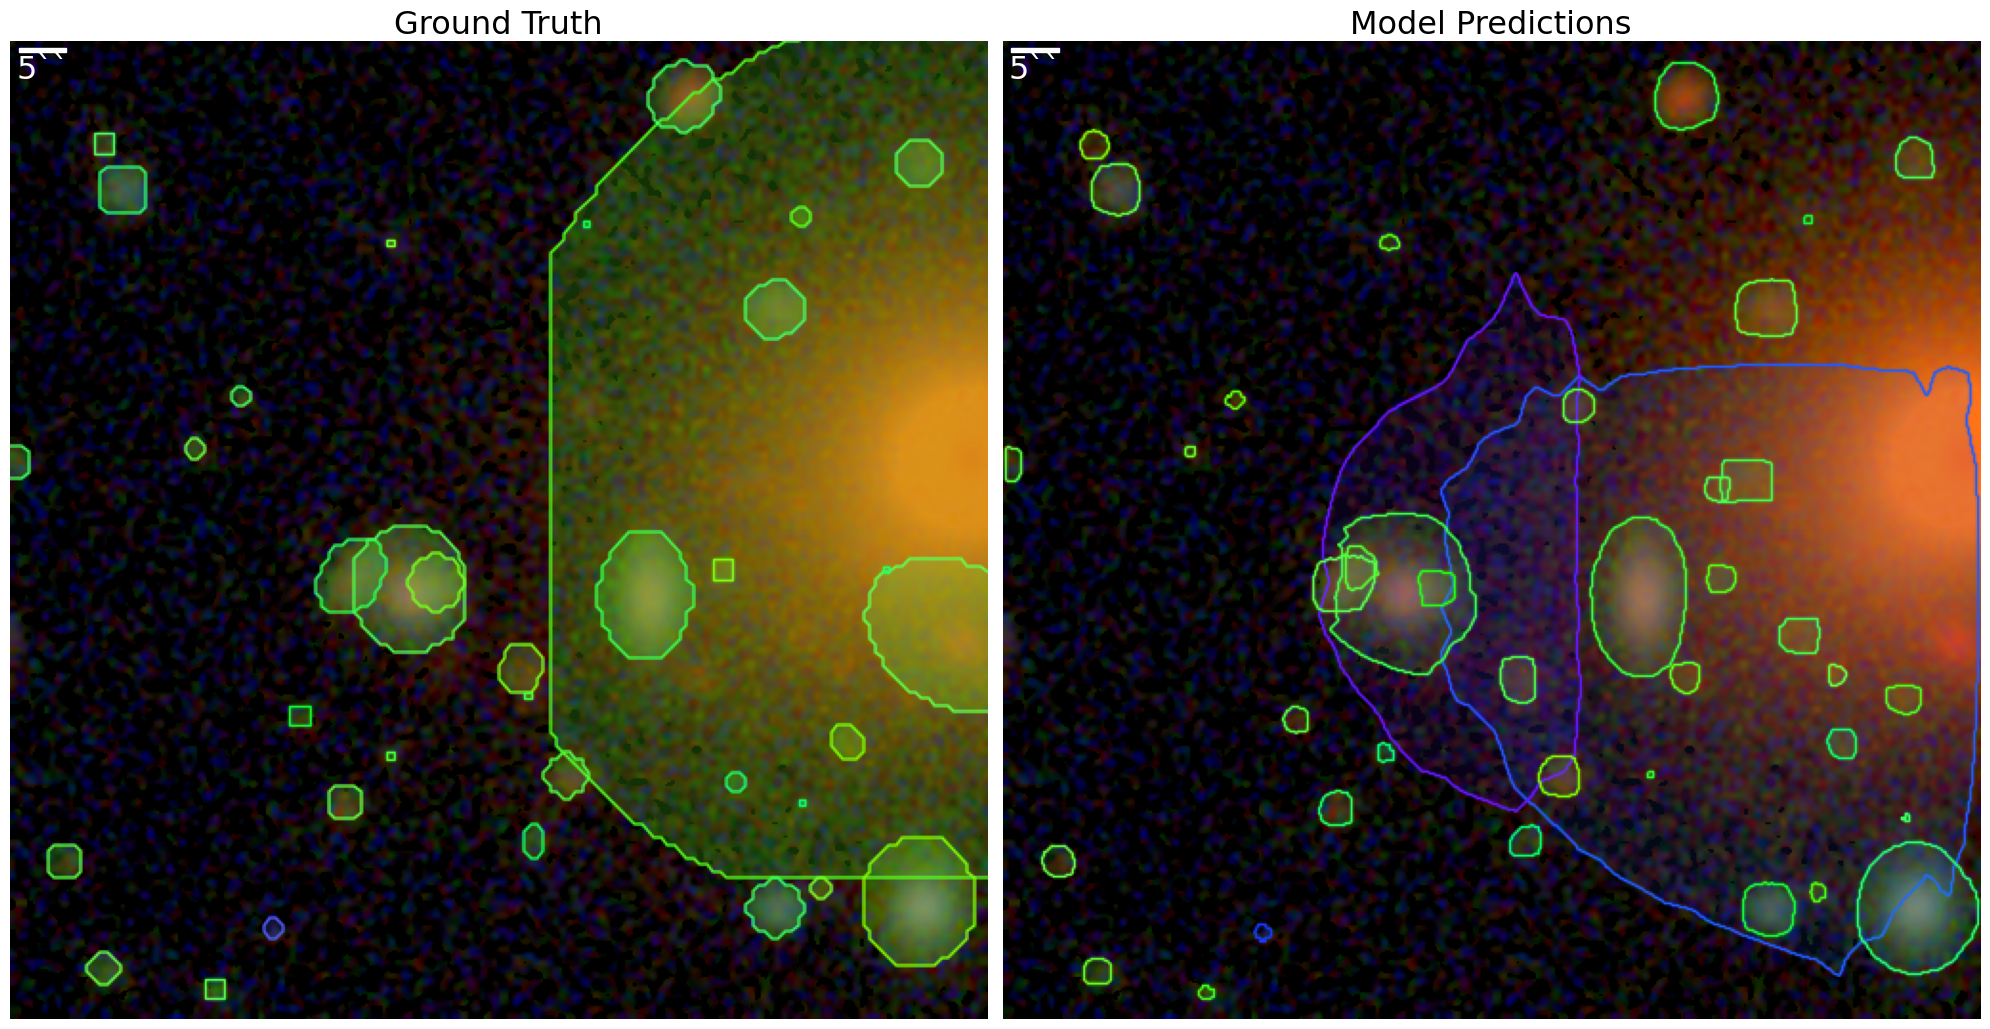

In [25]:
from deepdisc.astrodet.visualizer import Visualizer
from deepdisc.astrodet.visualizer import ColorMode
from astropy.visualization import make_lupton_rgb
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=23)

random_img = test_data[0]
key = img_key_mapper(random_img)
img = evaluator.imreader._read_image(key)
# img = make_lupton_rgb(img[:,:,2], img[:,:,3], img[:,:,4], minimum=0, stretch=50, Q=10)
img = make_lupton_rgb(img[:,:,2], img[:,:,1], img[:,:,0], minimum=0, stretch=0.5, Q=10)
fig, axes = plt.subplots(1, 2, figsize=(20, 15))
for ax in axes:
    ax.axis("off")

v_gt = Visualizer(
    img.copy(),
    metadata=evaluator.registered_test_data,
    scale=1,
    instance_mode=ColorMode.SEGMENTATION,
)
axes[0].set_title("Ground Truth", fontsize=23)
# print(random_img['file_name'])
ground_truth = v_gt.draw_dataset_dict(random_img, lf=False,alpha=0.2, boxf=False)
axes[0].imshow(ground_truth.get_image())

v = Visualizer(
    img,
    metadata=evaluator.registered_test_data,
    scale=1,
    instance_mode=ColorMode.SEGMENTATION,  # remove the colors of unsegmented pixels. This option is only available for segmentation models
)

axes[1].set_title("Model Predictions",fontsize=23)
outputs = evaluator.get_random_prediction(random_img)
prediction_output = v.draw_instance_predictions(outputs["instances"].to("cpu"), alpha=0.1,lf=False)
axes[1].imshow(prediction_output.get_image())

scalebar = AnchoredSizeBar(axes[0].transData,
                           25, '5``', 'upper left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=2,
                           fontproperties=fontprops)

axes[0].add_artist(scalebar)


scalebar = AnchoredSizeBar(axes[1].transData,
                           25, '5``', 'upper left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=2,
                           fontproperties=fontprops)

axes[1].add_artist(scalebar)

# axes[1].scatter(175.618416,247.179605,color='w',s=5)

plt.tight_layout()

# # save if needed
# output_path = os.path.join(run_dir, f"det_gt_{random_idx}.png")
# plt.savefig(output_path)
# print(f"Plots saved to {output_path}")
# filter out test set if obj extends beyond cutout
# center of obj outside cutout -> done by doing cut by filtering by bounds
# center is within cutout but bbdox is large enough such that it goes into a diff cutout -> check if bbox brushes up against the edge of the cutout
# figure out how many objs are truncated by analyzing the bbox coords and make a new cutout for that obj and run inference on the new test set

In [114]:
img.shape

(512, 512, 3)

In [111]:
gt_boxes = np.array([ann['bbox'] for ann in random_img['annotations']])
# gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
gt_boxes = structures.Boxes(torch.Tensor(gt_boxes))
# centers_gt = gt_boxes.get_centers().cpu().numpy()
# gt_coords = wcs.pixel_to_world(centers_gt[:,0],centers_gt[:,1])
# # print(gt_coords.ra.degree, type(gt_coords.ra.degree))
# gt_ras.append(gt_coords.ra.degree)
# gt_decs.append(gt_coords.dec.degree)

In [113]:
gt_boxes[1]

Boxes(tensor([[267.9467,   0.0000, 244.0533, 451.0476]]))

In [115]:
267.9467 + 244.0533

512.0

# Detection Completeness

In [34]:
def detection_completeness(dd_det_cat, test_truth_cat):
    # return 0 if truth catalog is empty
    if len(test_truth_cat) == 0:
        return 0.0
    ras = dd_det_cat.ra.values
    decs = dd_det_cat.dec.values
    coord = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)
    
    ras_2 = test_truth_cat.ra_truth_merged.values
    decs_2 = test_truth_cat.dec_truth_merged.values
    allcatalog = SkyCoord(ra=ras_2*u.degree, dec=decs_2*u.degree)
   
    idx, d2d, d3d = coord.match_to_catalog_sky(allcatalog)
    minds = np.where(d2d.to(u.arcsec).value<=0.5)
    comp = len(minds[0])/len(test_truth_cat)
    return comp

In [51]:
# just LSST images was 77%
lsst_test_truth = pd.read_json('/home/yse2/lsst_data/annotations/lsst_test_truth_cat.json')
lsst_test_det = pd.read_json('/home/yse2/lsst_data/annotations/lsst_test_det_cat.json')
dd_det_cat_df = pd.read_json('/home/yse2/lsst_runs/run2_sm/dd_test_det.json')

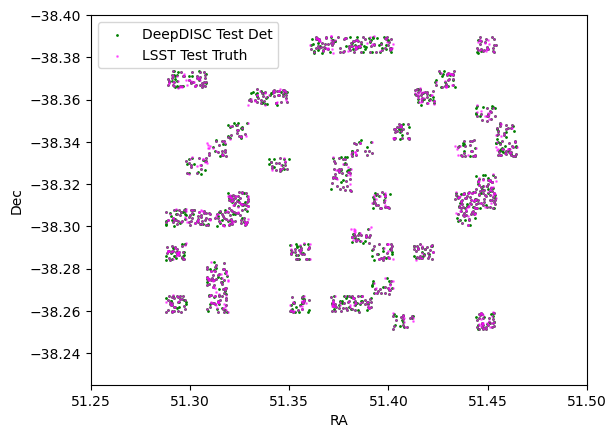

In [27]:
plt.scatter(dd_det_cat_df['ra'], dd_det_cat_df['dec'], s=1, c=['green'], label='DeepDISC Test Det')
plt.scatter(lsst_test_truth['ra_truth_merged'], lsst_test_truth['dec_truth_merged'], s=1, c=['magenta'], label='LSST Test Truth', alpha=0.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim(51.25,51.50)
plt.ylim(-38.225, -38.40)
plt.legend(loc='best')

In [36]:
detection_completeness(lsst_test_det, lsst_test_truth), "DeepDISC Completeness" , detection_completeness(dd_det_cat_df, lsst_test_truth), 
# (0.7330014769432744, 'DeepDISC Completeness', 0.779607242492205)

(0.7330014769432744, 'DeepDISC Completeness', 0.779607242492205)

In [52]:
mags = np.arange(min(lsst_test_truth['mag_i'].values), max(lsst_test_truth['mag_i'].values),0.5)
dcs = []
for i in range(1,len(mags)):
    dc = detection_completeness(dd_det_cat_df,lsst_test_truth.iloc[np.where(np.digitize(lsst_test_truth.mag_i.values, bins=mags)==i)])
    dcs.append(dc)

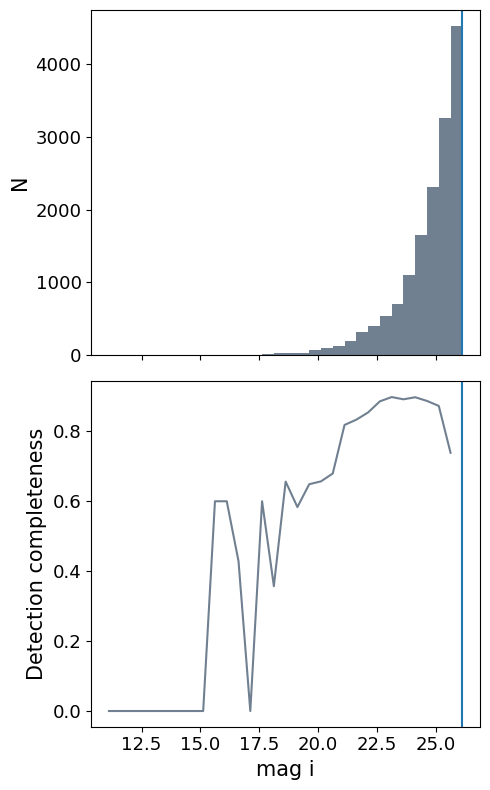

In [54]:
fig, ax = plt.subplots(2,1,figsize=(5,8),sharex=True)
ax[0].hist(lsst_test_truth.mag_i.values, bins=mags, color='slategrey')
ax[1].plot(mags[:-1], dcs, color='slategrey')
ax[1].set_xlabel('mag i',fontsize=15)
ax[0].set_ylabel('N',fontsize=15)
ax[1].set_ylabel('Detection completeness',fontsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[0].tick_params(axis='both', which='major', labelsize=13)
plt.tight_layout()
ax[1].axvline(max(mags))
ax[0].axvline(max(mags))

In [55]:
# combined images was 83%
lsst_test_truth = pd.read_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_truth_cat.json')
lsst_test_det = pd.read_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_det_cat.json')
dd_det_cat_df = pd.read_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_det.json')

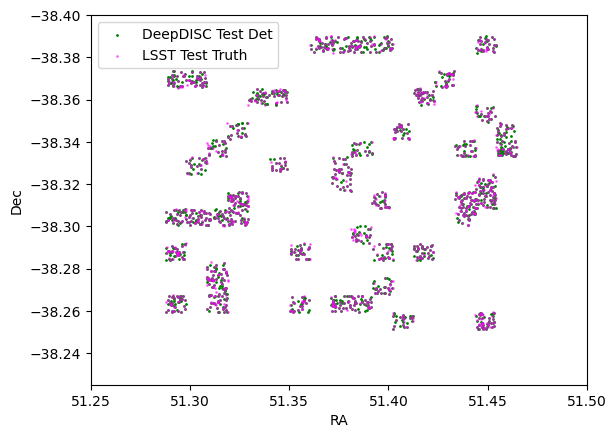

In [30]:
plt.scatter(dd_det_cat_df['ra'], dd_det_cat_df['dec'], s=1, c=['green'], label='DeepDISC Test Det')
plt.scatter(lsst_test_truth['ra_truth_merged'], lsst_test_truth['dec_truth_merged'], s=1, c=['magenta'], label='LSST Test Truth', alpha=0.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim(51.25,51.50)
plt.ylim(-38.225, -38.40)
plt.legend(loc='best')

In [47]:
detection_completeness(lsst_test_det, lsst_test_truth), "DeepDISC Completeness" ,detection_completeness(dd_det_cat_df, lsst_test_truth), 
# (0.733700092597636, 'DeepDISC Completeness', 0.8307642028432921)

(0.733700092597636, 'DeepDISC Completeness', 0.8307642028432921)

In [56]:
mags = np.arange(min(lsst_test_truth['mag_i'].values), max(lsst_test_truth['mag_i'].values),0.5)
dcs = []
for i in range(1,len(mags)):
    dc = detection_completeness(dd_det_cat_df,lsst_test_truth.iloc[np.where(np.digitize(lsst_test_truth.mag_i.values, bins=mags)==i)])
    dcs.append(dc)

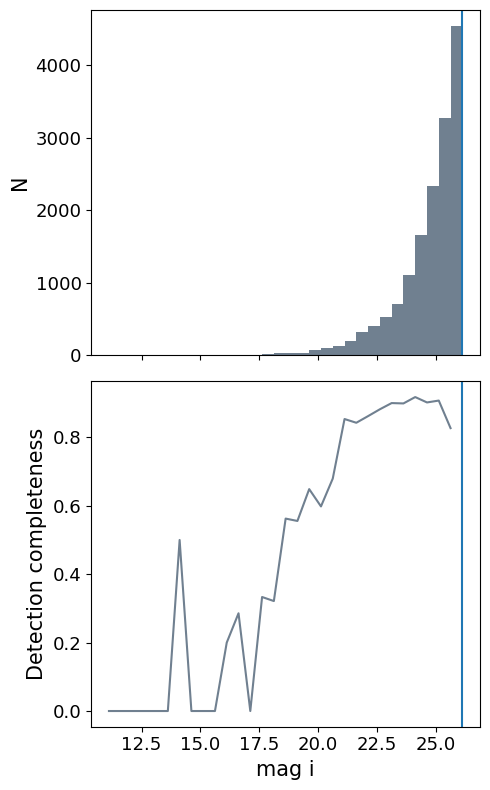

In [57]:
fig, ax = plt.subplots(2,1,figsize=(5,8),sharex=True)
ax[0].hist(lsst_test_truth.mag_i.values, bins=mags, color='slategrey')
ax[1].plot(mags[:-1], dcs, color='slategrey')
ax[1].set_xlabel('mag i',fontsize=15)
ax[0].set_ylabel('N',fontsize=15)
ax[1].set_ylabel('Detection completeness',fontsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[0].tick_params(axis='both', which='major', labelsize=13)
plt.tight_layout()
ax[1].axvline(max(mags))
ax[0].axvline(max(mags))

# 1-1 Matching of Det to Truth

In [58]:
# lsst_test_truth = pd.read_json('/home/yse2/lsst_data/annotations/lsst_test_truth_cat.json')
# lsst_test_det = pd.read_json('/home/yse2/lsst_data/annotations/lsst_test_det_cat.json')
# dd_det_cat_df = pd.read_json('/home/yse2/lsst_runs/run2_sm/dd_test_det.json')
lsst_test_truth = pd.read_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_truth_cat.json')
lsst_test_det = pd.read_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_det_cat.json')
dd_det_cat_df = pd.read_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_det.json')

In [59]:
# 2 less than magnitude based on cutoff
lsst_test_truth['mag_i'].describe()

count    18359.000000
mean        24.930973
std          1.450045
min         11.116846
25%         24.395074
50%         25.368793
75%         25.933767
max         26.439188
Name: mag_i, dtype: float64

In [60]:
def match_with_truth(det_cat, truth_cat, max_sep=0.5*u.arcsec):
    """
    Match detection catalog with truth catalog with search around sky
    Only keep 1-to-1 matches within max_sep
    """
    if len(det_cat) == 0:
        return pd.DataFrame(), pd.DataFrame()

    det_coords = SkyCoord(ra=det_cat['ra']*u.deg, 
                         dec=det_cat['dec']*u.deg)
    truth_coords = SkyCoord(ra=truth_cat['ra_truth_merged']*u.deg, 
                           dec=truth_cat['dec_truth_merged']*u.deg)
    
    idx_det, d2d, _ = det_coords.match_to_catalog_sky(truth_coords)
    good_sep = d2d <= max_sep
    # count how many truth objs match to each det and keep 1-to-1 matches
    unique_truth, truth_counts = np.unique(idx_det[good_sep], return_counts=True)
    good_truth = unique_truth[truth_counts == 1]
    
    final_mask = good_sep & np.isin(idx_det, good_truth)
    matched_det_indices = np.where(final_mask)[0]
    matched_truth_indices = idx_det[final_mask]
    
    matched_det = det_cat.iloc[matched_det_indices].copy()
    matched_truth = truth_cat.iloc[matched_truth_indices].copy()
    
    print(f"Found {len(matched_det)} matched pairs")
    
#     print(final_matches)
    return matched_det, matched_truth

In [61]:
len(lsst_test_det), len(lsst_test_truth), len(dd_det_cat_df)

(13827, 18359, 22263)

In [62]:
lsst_test_matched_det, lsst_test_matched_truth = match_with_truth(lsst_test_det, lsst_test_truth)

Found 13461 matched pairs


In [73]:
# lsst_test_matched_det.to_json('/home/yse2/lsst_data/annotations/lsst_test_det11_cat.json', orient='records')
# lsst_test_matched_truth.to_json('/home/yse2/lsst_data/annotations/lsst_test_truth11_cat.json', orient='records')

lsst_test_matched_det.to_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_det11_cat.json', orient='records')
lsst_test_matched_truth.to_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_truth11_cat.json', orient='records')

In [63]:
dd_matched_det, dd_matched_truth = match_with_truth(dd_det_cat_df, lsst_test_truth)

Found 15026 matched pairs


In [64]:
dd_matched_det = pd.read_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_det11.json', orient='records')
dd_matched_truth = pd.read_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_truth11.json', orient='records')

# Obj Properties

In [75]:
import seaborn as sns
from matplotlib.gridspec import GridSpec
def generate_obj_plots(truth_cat):
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 3, figure=fig)

    # size vs mag scatter
    ax1 = fig.add_subplot(gs[0, :2])
    scatter = ax1.scatter(truth_cat['mag_i'], 
                         truth_cat['size_true'],
                         c=truth_cat['redshift_truth_merged'],
                         alpha=0.5, cmap='viridis')
    ax1.set_xlabel('mag i')
    ax1.set_ylabel('True Size (arcsec)')
    ax1.set_title('Size vs Mag colored by Redshift')
    plt.colorbar(scatter, ax=ax1, label='Redshift') # where blue/purple means lower redshifts (closer objs) and yellow/green means higher redshifts (more distant objs)

    # mag hist
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.hist(truth_cat['mag_i'], bins=50)
    ax2.set_xlabel('mag i')
    ax2.set_ylabel('Count')
    ax2.set_title('Mag Distribution')

    # size hist
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.hist(truth_cat['size_true'], bins=50)
    ax3.set_xlabel('Size (arcsec)')
    ax3.set_ylabel('Count')
    ax3.set_title('Size Distribution')

    # ellip distribution
    ax4 = fig.add_subplot(gs[1, 1])
    e1 = truth_cat['ellipticity_1_true']
    e2 = truth_cat['ellipticity_2_true']
    ax4.scatter(e1, e2, alpha=0.5, s=1)
    ax4.set_xlabel('e1')
    ax4.set_ylabel('e2')
    ax4.set_title('Ellipticity Distribution')
    ax4.set_aspect('equal')

    # redshift histogram
    ax5 = fig.add_subplot(gs[1, 2])
    ax5.hist(truth_cat['redshift_truth_merged'], bins=50)
    ax5.set_xlabel('Redshift')
    ax5.set_ylabel('Count')
    ax5.set_title('Redshift Distribution')

    plt.tight_layout()
    
def generate_box_plots(truth_cat):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    # size by type
    sns.boxplot(data=truth_cat, x='truth_type', y='size_true', ax=axes[0,0])
    axes[0,0].set_title('Size Distribution by Object Type')
    axes[0,0].set_xlabel('Object Type (1=galaxy, 2=star)')

    sns.boxplot(data=truth_cat, x='truth_type', y='mag_i', ax=axes[0,1])
    axes[0,1].set_title('Mag i Distribution by Object Type')
    axes[0,1].set_xlabel('Object Type (1=galaxy, 2=star)')

    e_tot = np.sqrt(truth_cat['ellipticity_1_true']**2 + 
                    truth_cat['ellipticity_2_true']**2)
    truth_cat['total_ellipticity'] = e_tot
    sns.boxplot(data=truth_cat, x='truth_type', y='total_ellipticity', ax=axes[1,0])
    axes[1,0].set_title('Total Ellipticity by Object Type')
    axes[1,0].set_xlabel('Object Type (1=galaxy, 2=star)')

    sns.boxplot(data=truth_cat, x='truth_type', y='redshift_truth_merged', ax=axes[1,1])
    axes[1,1].set_title('Redshift Distribution by Object Type')
    axes[1,1].set_xlabel('Object Type (1=galaxy, 2=star)')

    plt.tight_layout()

## LSST Test Truth Objects

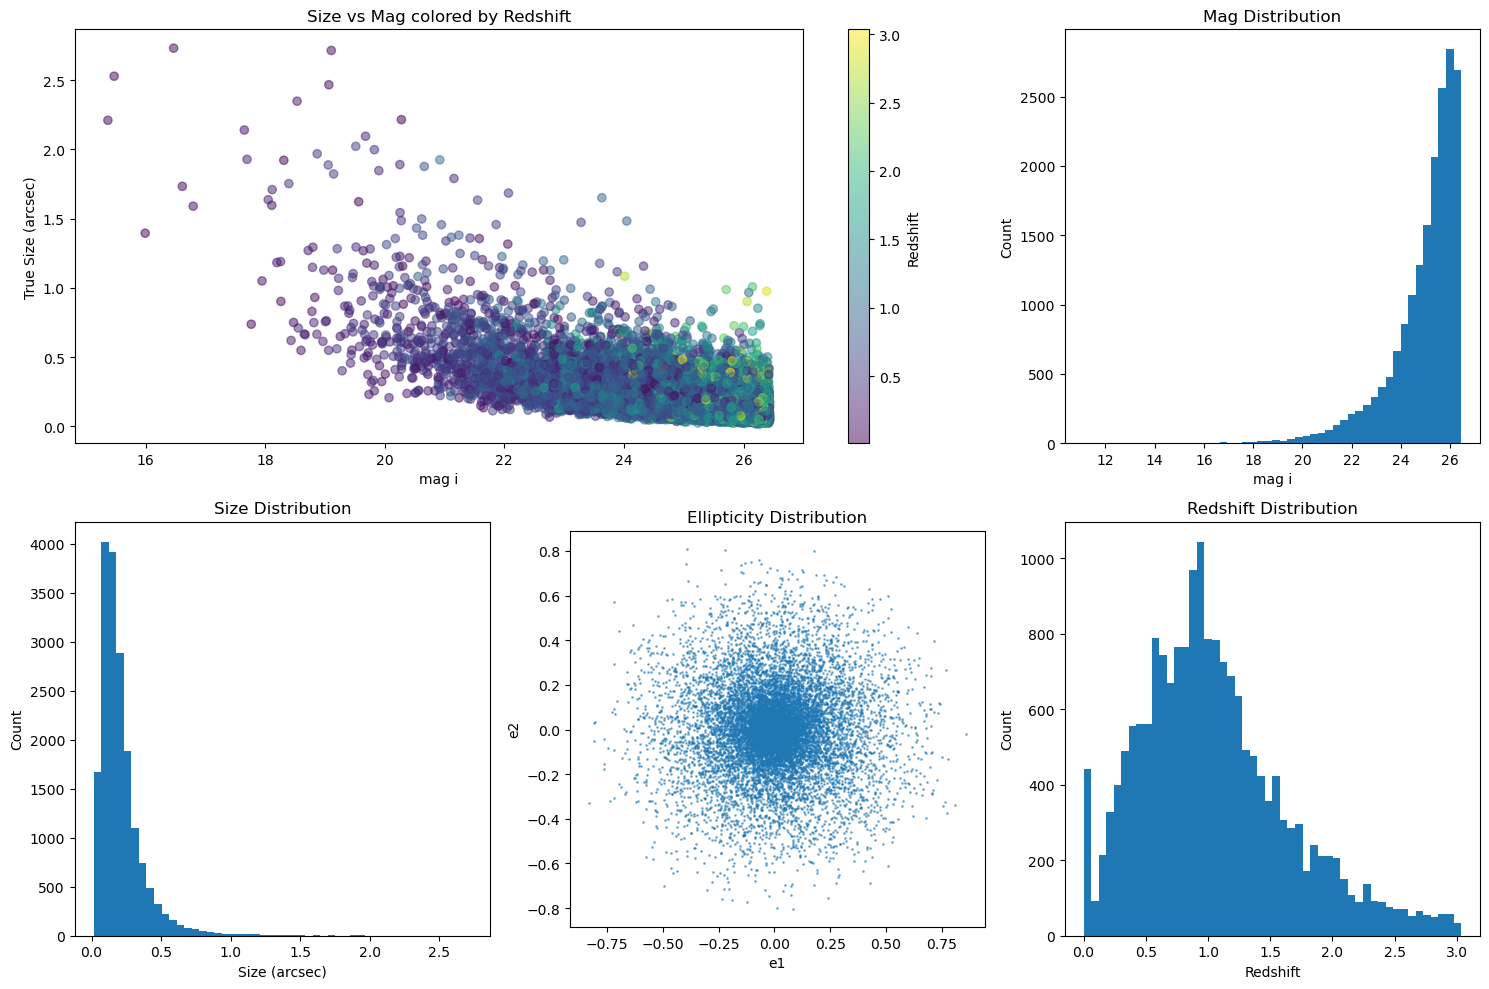

In [69]:
generate_obj_plots(lsst_test_truth)

## Matched LSST Det and LSST Truth Objs

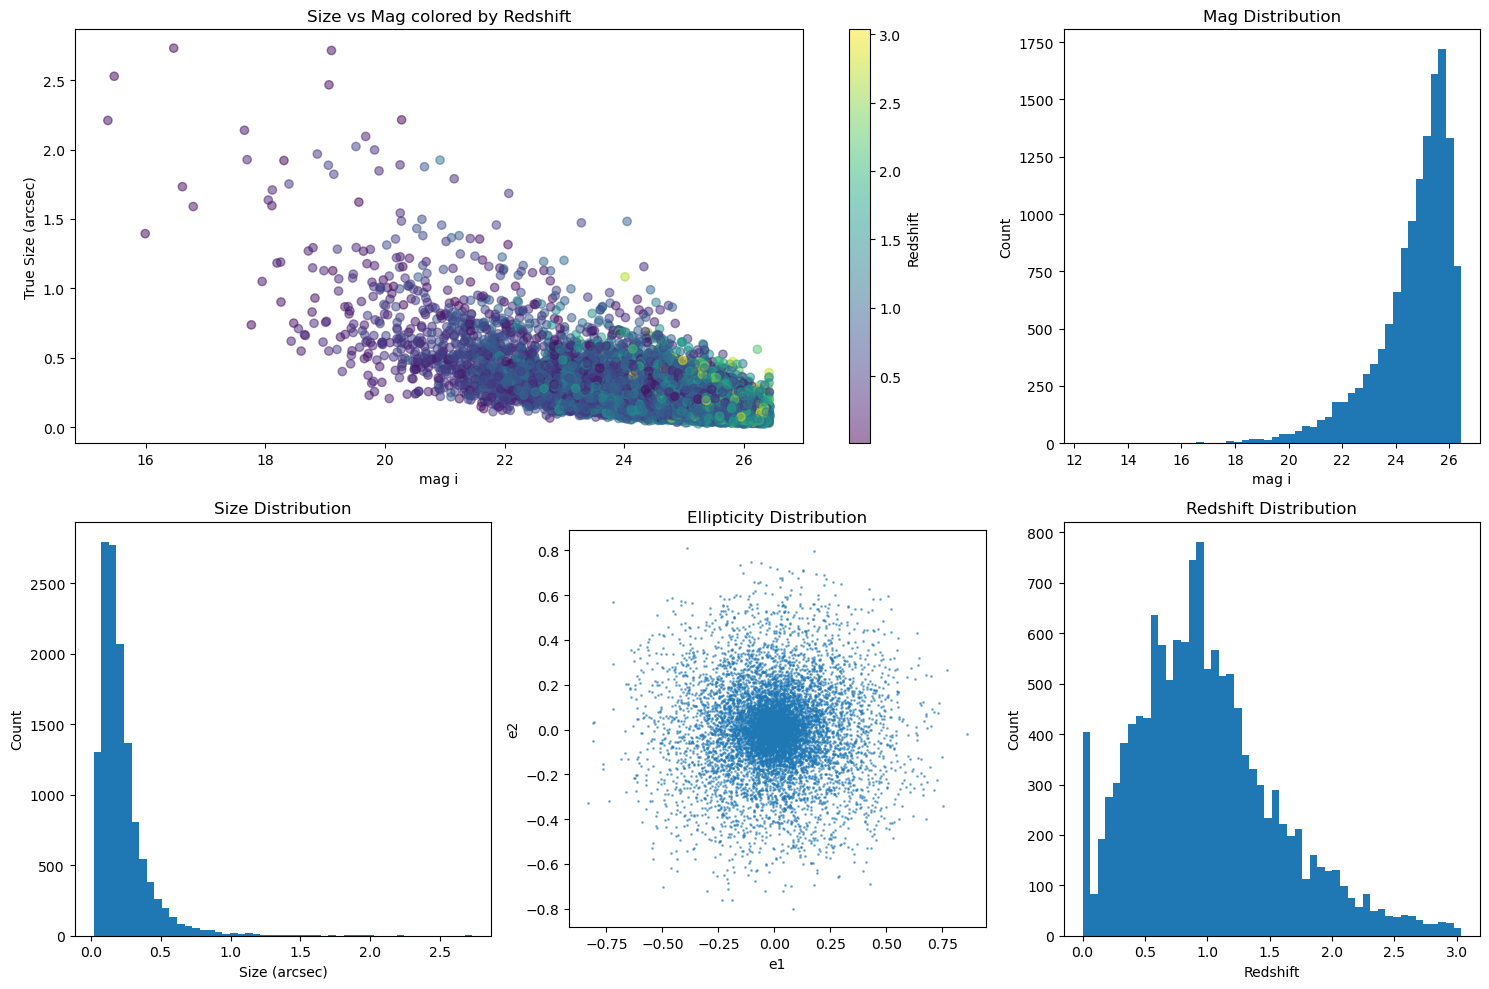

In [70]:
generate_obj_plots(lsst_test_matched_truth)

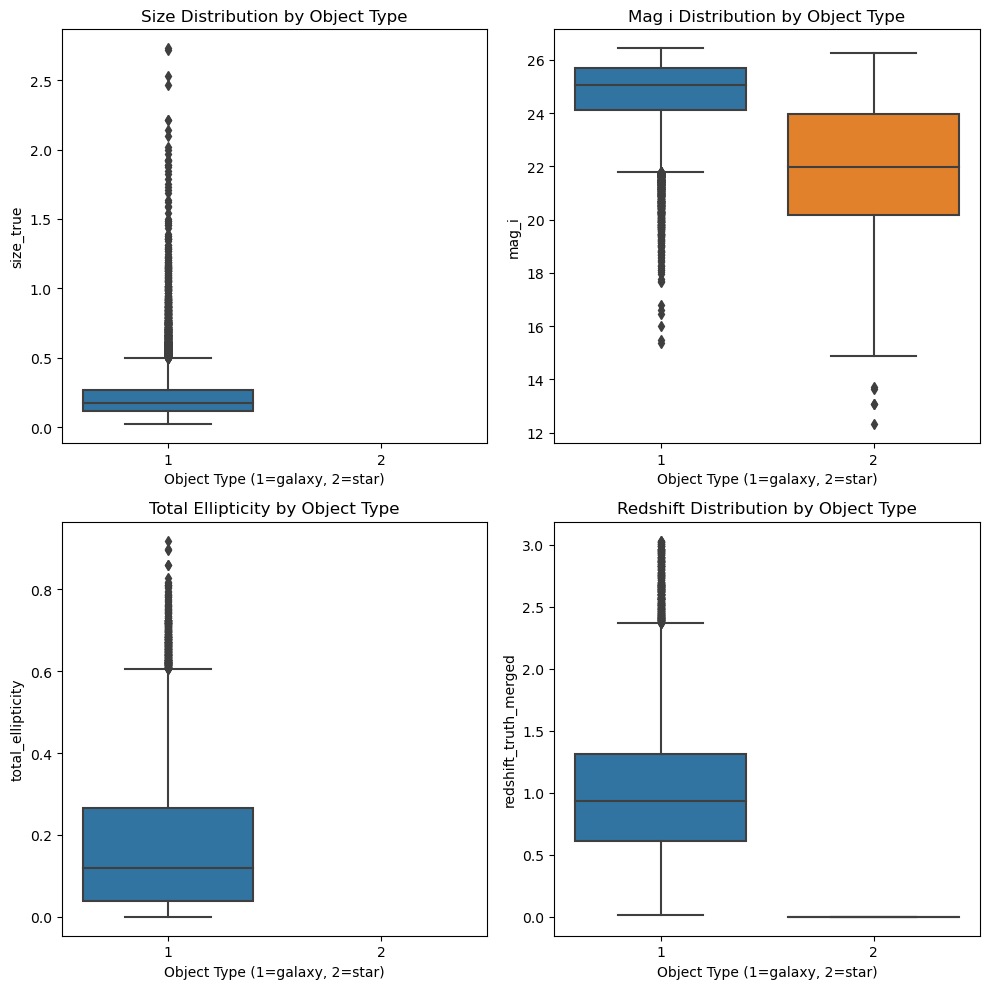

In [76]:
generate_box_plots(lsst_test_matched_truth)

## Matched DeepDISC and LSST Truth Objs

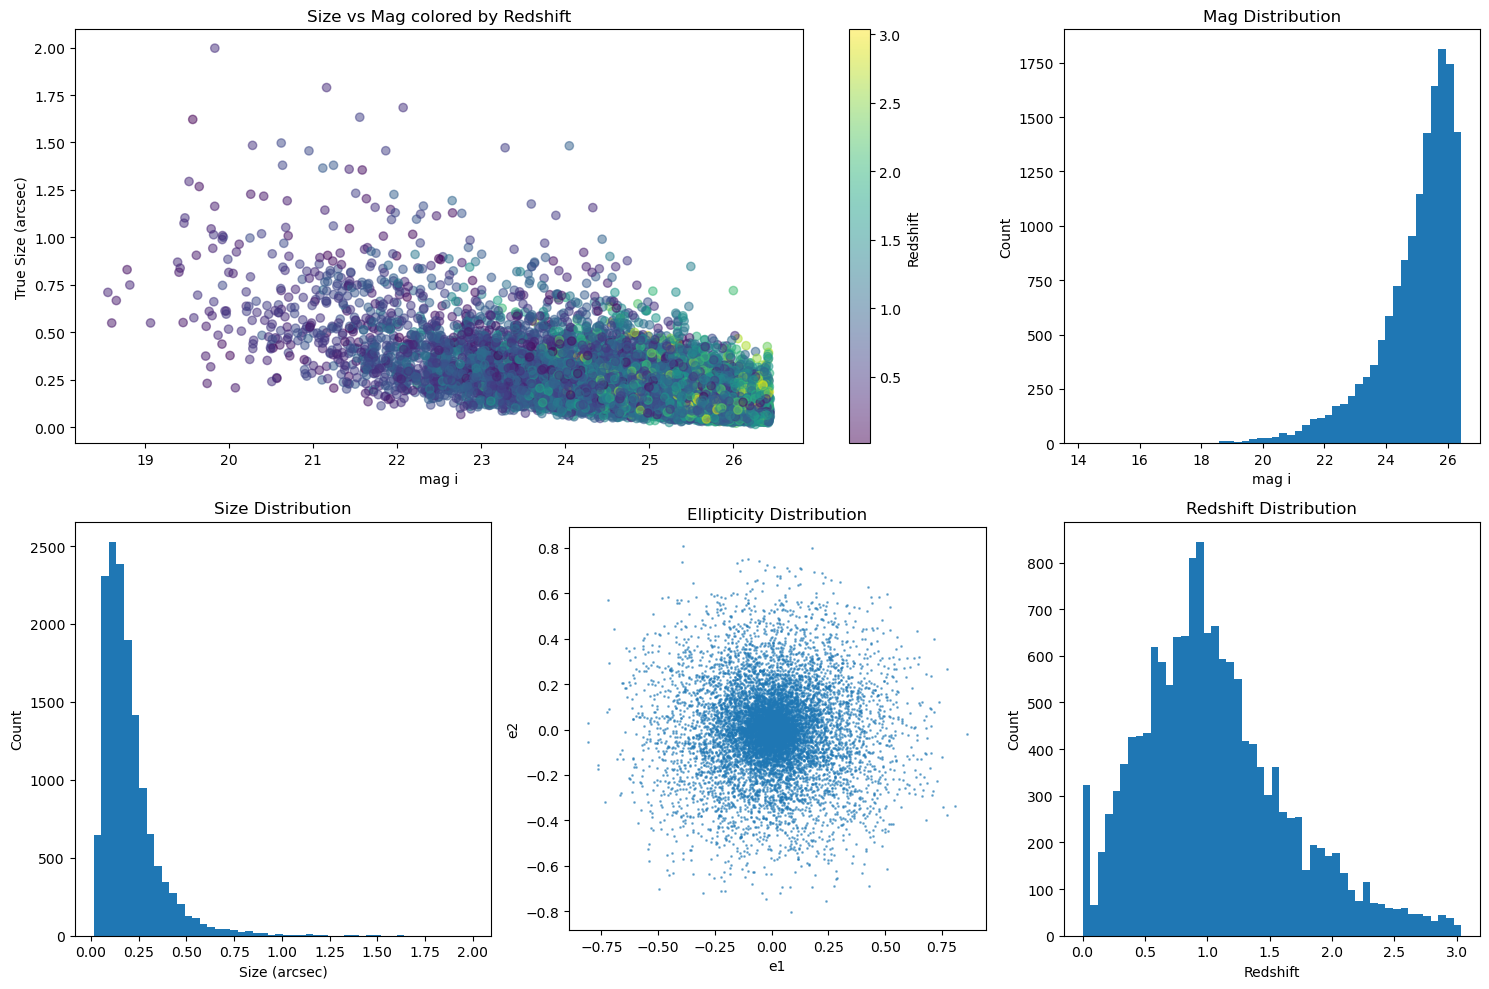

In [68]:
generate_obj_plots(dd_matched_truth)

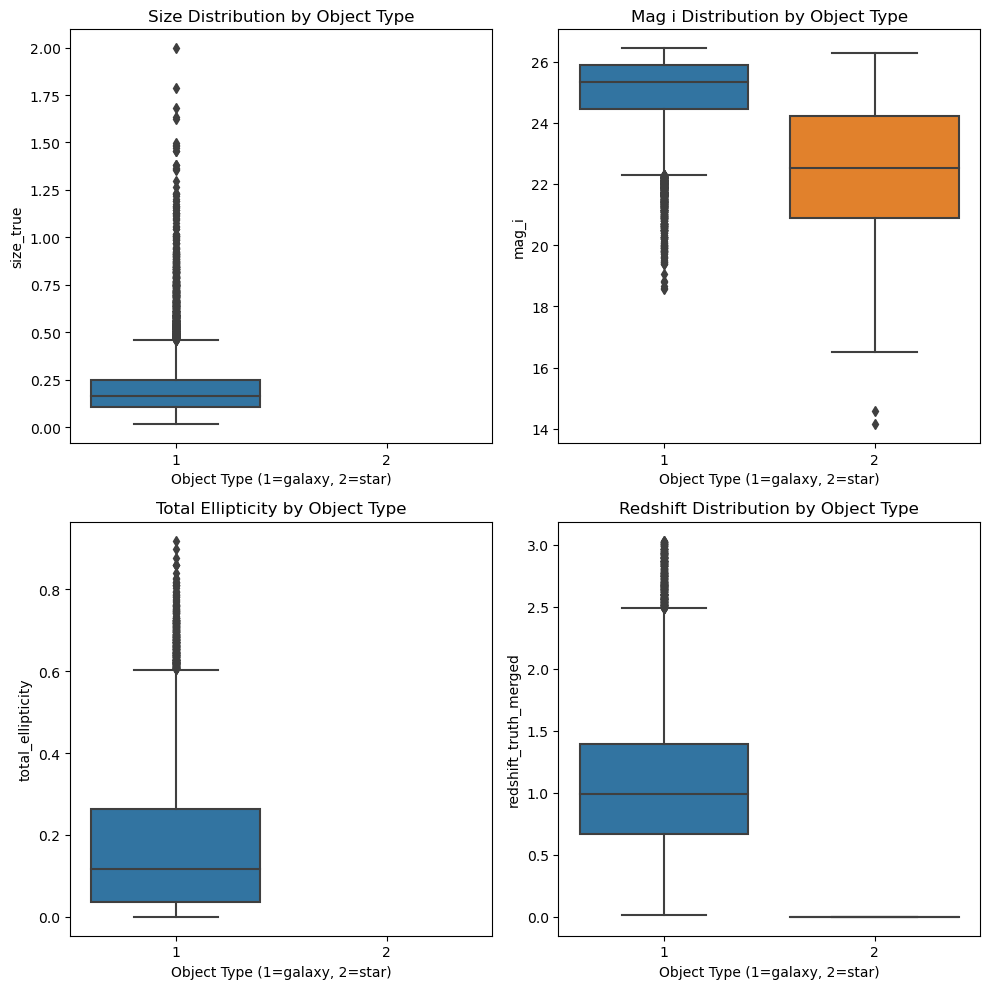

In [77]:
generate_box_plots(dd_matched_truth)

# 2D Histogram FOF Plot

In [79]:
# does same mag cut to truth that detection also has
def get_lsst_cat_ras_decs(lsst_cat, cat_type):
    lsst_df = pd.DataFrame()
    ra_dec_df = None
    if cat_type == 'truth':
        lsst_df = lsst_cat[(lsst_cat['mag_i'] < 27)]
        ra_dec_df = lsst_df[['ra_truth_merged','dec_truth_merged']]
        ra_dec_df = ra_dec_df.rename(columns={'ra_truth_merged': 'ra', 'dec_truth_merged': 'dec'})
        mags = lsst_df['mag_i']
    else: # det catalog
        lsst_df = lsst_cat[(lsst_cat['mag_i'] < 27)]
        ra_dec_df = lsst_df[['ra','dec']]
        mags = lsst_df['mag_i']
    return Table.from_pandas(ra_dec_df), list(mags)

In [81]:
import FoFCatalogMatching
# points within 1 arcsecs of each other are grouped together only if there's no more than 3 friends within 1 arcsec
# None following distance means points are grouped together without any constraint on number of friends
def find_matches(cat_a, cat_b, cat_a_name, cat_b_name, linking_length=1.0, max_friends=1):
    """
    Find matches between two catalogs using Friends-of-Friends algorithm.
    
    Parameters:
    -----------
    cat_a, cat_b : astropy.table.Table
        The two catalogs to match.
    cat_a_name, cat_b_name : str
        Names for the two catalogs.
    linking_length : float, optional
        The linking length in arcseconds. Default is 0.5.
    max_friends : int or None, optional
        The maximum number of friends allowed in a group. 
        Use None for no limit. Default is 1.
    
    Returns:
    --------
    astropy.table.Table
        Matched catalog with group IDs.
    """
    # first linking length groups points within that distance, limited by max_friends
    linking_lengths = {linking_length: max_friends}
    # use lsst truth catalog to get 1-1 match with LSST Det/Roman Det to recreat Fig 11 from Troxel Paper     
    return FoFCatalogMatching.match({cat_a_name: cat_a, cat_b_name: cat_b},
                               linking_lengths)

In [85]:
# Adapted from https://nbviewer.org/github/LSSTDESC/DC2-analysis/blob/rendered/tutorials/matching_fof.nbconvert.ipynb
def autofit_text(ax, text, x, y):
    fontsize = 11
    bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="none", alpha=0)

    while fontsize > 1:
        t = ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, 
                    color='white', bbox=bbox_props)
        
        # grab the renderer
        r = ax.figure.canvas.get_renderer()
        bb = t.get_window_extent(renderer=r).transformed(ax.transData.inverted())
        
        # check if text fits within the cell
        if bb.width < 1 and bb.height < 1:
            return
        
        t.remove()
        fontsize -= 1

    # if we got here, text is too large to fit at any readable size
    ax.text(x, y, '.', ha='center', va='center', fontsize=8, color='white')
    
def plot_matches(results, x_axis_name, xlabel, ylabel):
    # now we want to count the number of cat a and cat b objects *for each group*
    # but instead of looping over groups, we can do this

    # first we need to know which rows are from the x-axis cat (catalog A) and which are from y-axis cat (catalog B)
    cat_a_mask = results['catalog_key'] == x_axis_name
    cat_b_mask = ~cat_a_mask

    # then np.bincount will give num of id occurrences in each group (like historgram but with int input)
    n_groups = results['group_id'].max() + 1
    n_a = np.bincount(results['group_id'][cat_a_mask], minlength=n_groups)
    # print(n_truth[n_truth>10])
    n_b = np.bincount(results['group_id'][cat_b_mask], minlength=n_groups)
    # unique, counts = np.unique(n_a, return_counts=True)
    # print("n_a:", dict(zip(unique, counts)))
    # unique2, counts2 = np.unique(n_b, return_counts=True)
    # print("n_b:", dict(zip(unique2, counts2)))

    # now n_a and n_b are the number of cat a/cat b objects in each group
    # we want to make a 2d histrogram of (n_a, n_b). 
    n_max = max(n_a.max(), n_b.max()) + 1
    hist_2d = np.bincount(n_b * n_max + n_a, minlength=n_max*n_max).reshape(n_max, n_max) # how we want to visualize our histograms
    # hist_2d = np.bincount(n_b * n_max + n_a, minlength=n_max*n_max).reshape(n_max, n_max) # how they choose to visualize their histograms
    plt.figure(figsize=(12,10))
    plt.imshow(np.log10(hist_2d+1), extent=(-0.5, n_max-0.5, -0.5, n_max-0.5), origin='lower', cmap='Oranges')
    plt.xlabel(f'Number of {xlabel}')
    plt.ylabel(f'Number of {ylabel}')
    plt.colorbar(label=r'$\log(N_{\rm groups} \, + \, 1)$')
    ax = plt.gca()
    for i in range(n_max):
        for j in range(n_max):
            if hist_2d[i, j] > 0:
                text = str(hist_2d[i, j])
                autofit_text(ax, text, j, i)

## DeepDISC vs LSST Det

In [83]:
dd_test_det = pd.read_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_det11.json')
lsst_test_det = pd.read_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_det11_cat.json')

lsst_test_det = lsst_test_det.drop_duplicates(subset=['ra', 'dec'])

dd_det_table = Table.from_pandas(dd_test_det)
lsst_test_det_table, test_det_mags = get_lsst_cat_ras_decs(lsst_test_det, cat_type='det')

In [84]:
# cat a will be on x axis
# cat b will be on y axis
cat_a_name = 'lsst_test_det'
cat_b_name = 'dd_det'
dd_det_lsst_det1 = find_matches(cat_a=lsst_test_det_table, cat_b=dd_test_det,  cat_a_name=cat_a_name, cat_b_name=cat_b_name)
dd_det_lsst_det05 = find_matches(cat_a=lsst_test_det_table, cat_b=dd_test_det,  cat_a_name=cat_a_name, cat_b_name=cat_b_name, linking_length=0.5)

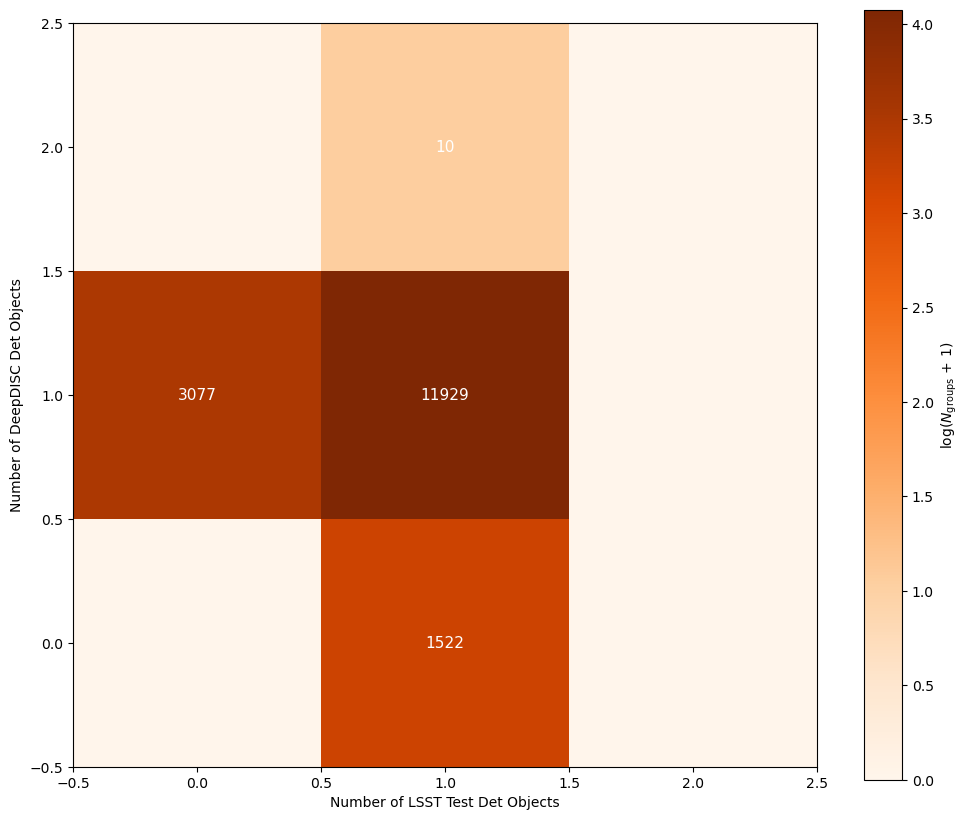

In [89]:
plot_matches(dd_det_lsst_det05, x_axis_name='lsst_test_det', xlabel='LSST Test Det Objects', ylabel='DeepDISC Det Objects')

In [90]:
def get_unmatched_objects(fof_results, dd_det_info, cat_a_name='lsst_test_det'):
    """
    Extract objects that were detected by DeepDISC but not matched 1-1 with LSST detections
    """
    # group IDs where LSST has 0 detections and DeepDISC has 1
    cat_a_mask = fof_results['catalog_key'] == cat_a_name
    cat_b_mask = ~cat_a_mask
    
    n_groups = fof_results['group_id'].max() + 1
    n_a = np.bincount(fof_results['group_id'][cat_a_mask], minlength=n_groups)
    n_b = np.bincount(fof_results['group_id'][cat_b_mask], minlength=n_groups)
    
    # groups where LSST has 0 detections and DeepDISC has 1
    target_groups = np.where((n_a == 0) & (n_b == 1))[0]
    
    # DeepDISC detections in these groups
    dd_mask = cat_b_mask & np.isin(fof_results['group_id'], target_groups)
    dd_indices = np.where(dd_mask)[0]
    
    # ra/dec from FOF results for these objects
    unmatched_ras = fof_results['ra'][dd_indices]
    unmatched_decs = fof_results['dec'][dd_indices]
    
    # matching back to full DeepDISC detection catalog to get all information
    dd_coords = SkyCoord(ra=dd_det_info['ra']*u.deg, dec=dd_det_info['dec']*u.deg)
    unmatched_coords = SkyCoord(ra=unmatched_ras*u.deg, dec=unmatched_decs*u.deg)
    
    idx, d2d, _ = unmatched_coords.match_to_catalog_sky(dd_coords)
    # keep exact matches
    exact_matches = d2d <= 0.0001*u.arcsec
    
    return dd_det_info.iloc[idx[exact_matches]]

In [99]:
def get_unmatched_objects(fof_results, dd_det_info, dd_truth_info, cat_a_name='lsst_test_det'):
    """
    Extract objects that were detected by DeepDISC but not matched 1-1 with LSST detections
    """
    # Get group IDs where LSST has 0 detections and DeepDISC has 1
    cat_a_mask = fof_results['catalog_key'] == cat_a_name
    cat_b_mask = ~cat_a_mask
    
    n_groups = fof_results['group_id'].max() + 1
    n_a = np.bincount(fof_results['group_id'][cat_a_mask], minlength=n_groups)
    n_b = np.bincount(fof_results['group_id'][cat_b_mask], minlength=n_groups)
    
    # Find groups where LSST has 0 detections and DeepDISC has 1
    target_groups = np.where((n_a == 0) & (n_b == 1))[0]
    
    # Get DeepDISC rows in these groups
    dd_mask = cat_b_mask & np.isin(fof_results['group_id'], target_groups)
    dd_indices = fof_results[dd_mask]['row_index']
    
    # Use these indices to get full object properties from the truth catalog
    unmatched_objects = dd_truth_info.iloc[dd_indices]
    
    return unmatched_objects

def plot_unmatched_properties(unmatched_objects):
    """
    Create visualization plots for properties of unmatched objects
    """
    fig = plt.figure(figsize=(15, 12))
    
    # Plot spatial distribution
    ax1 = plt.subplot(231)
    ax1.scatter(unmatched_objects['ra_truth_merged'], unmatched_objects['dec_truth_merged'], 
               s=1, alpha=0.5, c='red')
    ax1.set_xlabel('RA')
    ax1.set_ylabel('Dec')
    ax1.set_title('Spatial Distribution')
    
    # Plot magnitude distribution
    ax2 = plt.subplot(232)
    ax2.hist(unmatched_objects['mag_i'], bins=30)
    ax2.set_xlabel('mag i')
    ax2.set_ylabel('Count')
    ax2.set_title('Magnitude Distribution')
    
    # Plot size distribution
    ax3 = plt.subplot(233)
    if 'size_true' in unmatched_objects.columns:
        ax3.hist(unmatched_objects['size_true'], bins=30)
        ax3.set_xlabel('Size (arcsec)')
        ax3.set_ylabel('Count')
        ax3.set_title('Size Distribution')
    
    # Plot redshift distribution
    ax4 = plt.subplot(234)
    ax4.hist(unmatched_objects['redshift_truth_merged'], bins=30)
    ax4.set_xlabel('Redshift')
    ax4.set_ylabel('Count')
    ax4.set_title('Redshift Distribution')
    
    # Plot object type distribution
    ax5 = plt.subplot(235)
    if 'truth_type' in unmatched_objects.columns:
        type_counts = unmatched_objects['truth_type'].value_counts()
        ax5.bar(['Galaxy' if t==1 else 'Star' for t in type_counts.index], 
                type_counts.values)
        ax5.set_ylabel('Count')
        ax5.set_title('Object Type Distribution')
    
    # Plot ellipticity distribution if available
    ax6 = plt.subplot(236)
    if 'ellipticity_1_true' in unmatched_objects.columns:
        ax6.scatter(unmatched_objects['ellipticity_1_true'], 
                   unmatched_objects['ellipticity_2_true'],
                   s=1, alpha=0.5)
        ax6.set_xlabel('e1')
        ax6.set_ylabel('e2')
        ax6.set_title('Ellipticity Distribution')
        ax6.set_aspect('equal')
    
    plt.tight_layout()
    return fig

def print_statistics(unmatched_objects):
    """
    Print summary statistics for unmatched objects
    """
    print("\nUnmatched Object Statistics:")
    print("-" * 50)
    print(f"Total number of unmatched objects: {len(unmatched_objects)}")
    
    if 'truth_type' in unmatched_objects.columns:
        type_counts = unmatched_objects['truth_type'].value_counts()
        print("\nObject Type Distribution:")
        for t, count in type_counts.items():
            print(f"{'Galaxy' if t==1 else 'Star'}: {count} ({100*count/len(unmatched_objects):.1f}%)")
    
    print("\nMagnitude Statistics:")
    print(unmatched_objects['mag_i'].describe())
    
    if 'size_true' in unmatched_objects.columns:
        print("\nSize Statistics (arcsec):")
        print(unmatched_objects['size_true'].describe())
    
    print("\nRedshift Statistics:")
    print(unmatched_objects['redshift_truth_merged'].describe())

def analyze_unmatched_objects(fof_results, dd_det_info, dd_truth_info, cat_a_name='lsst_test_det'):
    """
    Main analysis function to extract and visualize unmatched objects
    """
    # Get unmatched objects
    unmatched = get_unmatched_objects(fof_results, dd_det_info, dd_truth_info, cat_a_name)
    
    # Create plots
    fig = plot_unmatched_properties(unmatched)
    
    # Print statistics
    print_statistics(unmatched)
    
    return unmatched, fig


Unmatched Object Statistics:
--------------------------------------------------
Total number of unmatched objects: 3077

Object Type Distribution:
Galaxy: 3060 (99.4%)
Star: 17 (0.6%)

Magnitude Statistics:
count    3077.000000
mean       25.790258
std         0.723845
min        14.141115
25%        25.601597
50%        25.990858
75%        26.236403
max        26.438667
Name: mag_i, dtype: float64

Size Statistics (arcsec):
count    3060.000000
mean        0.161687
std         0.112327
min         0.014233
25%         0.085584
50%         0.134900
75%         0.206578
max         1.633192
Name: size_true, dtype: float64

Redshift Statistics:
count    3077.000000
mean        1.245137
std         0.627498
min         0.000000
25%         0.813334
50%         1.131549
75%         1.599043
max         3.033423
Name: redshift_truth_merged, dtype: float64


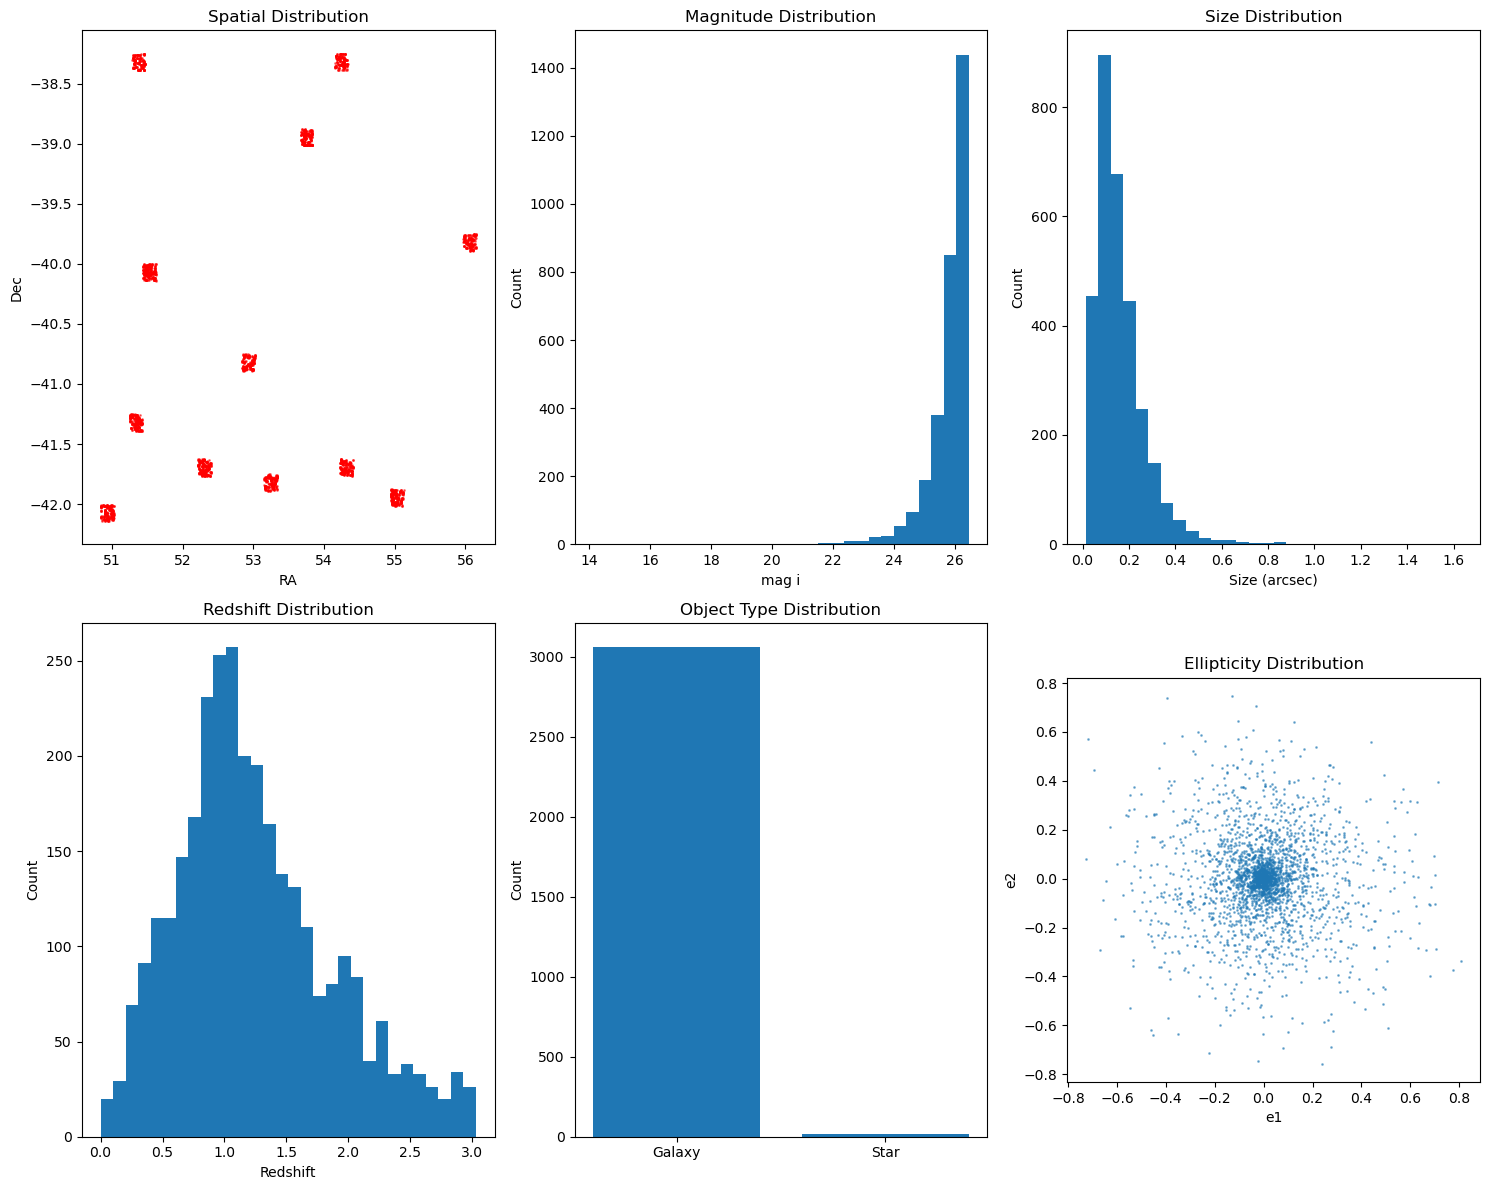

In [98]:
dd_det_info = pd.read_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_det_info.json')
dd_truth_info = pd.read_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_truth11.json', orient='records')

unmatched_objects, fig = analyze_unmatched_objects(dd_det_lsst_det05, dd_det_info, dd_truth_info)

# unmatched_objects.to_json('/home/yse2/lsst_runs/run4_ups_roman/unmatched_objects.json', orient='records')

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.coordinates import SkyCoord
import astropy.units as u

def get_unmatched_objects(fof_results, dd_truth_info, cat_a_name='lsst_test_det'):
    """
    Extract objects that were detected by DeepDISC but not matched 1-1 with LSST detections
    """
    # Get group IDs where LSST has 0 detections and DeepDISC has 1
    cat_a_mask = fof_results['catalog_key'] == cat_a_name
    cat_b_mask = ~cat_a_mask
    
    n_groups = fof_results['group_id'].max() + 1
    n_a = np.bincount(fof_results['group_id'][cat_a_mask], minlength=n_groups)
    n_b = np.bincount(fof_results['group_id'][cat_b_mask], minlength=n_groups)
    
    # Find groups where LSST has 0 detections and DeepDISC has 1
    target_groups = np.where((n_a == 0) & (n_b == 1))[0]
    
    # Get DeepDISC rows in these groups
    dd_mask = cat_b_mask & np.isin(fof_results['group_id'], target_groups)
    dd_indices = fof_results[dd_mask]['row_index']
    
    # Use these indices to get full object properties from the truth catalog
    unmatched_objects = dd_truth_info.iloc[dd_indices]
    
    return unmatched_objects

def get_unmatched_objects2(fof_results, dd_truth_info, cat_a_name='lsst_test_det'):
    """
    Extract objects that were detected by DeepDISC but not matched 1-1 with LSST detections
    """
    # Get group IDs where LSST has 0 detections and DeepDISC has 1
    cat_a_mask = fof_results['catalog_key'] == cat_a_name
    cat_b_mask = ~cat_a_mask
    
    n_groups = fof_results['group_id'].max() + 1
    n_a = np.bincount(fof_results['group_id'][cat_a_mask], minlength=n_groups)
    n_b = np.bincount(fof_results['group_id'][cat_b_mask], minlength=n_groups)
    
    # Find groups where LSST has 1 detections and DeepDISC has 2
    target_groups = np.where((n_a == 1) & (n_b == 2))[0]
    
    # Get DeepDISC rows in these groups
    dd_mask = cat_b_mask & np.isin(fof_results['group_id'], target_groups)
    dd_indices = fof_results[dd_mask]['row_index']
    
    # Use these indices to get full object properties from the truth catalog
    unmatched_objects = dd_truth_info.iloc[dd_indices]
    
    return unmatched_objects

def print_statistics(unmatched_objects):
    """
    Print summary statistics for unmatched objects
    """
    print("\nUnmatched Object Statistics:")
    print("-" * 50)
    print(f"Total number of unmatched objects: {len(unmatched_objects)}")
    
    if 'truth_type' in unmatched_objects.columns:
        type_counts = unmatched_objects['truth_type'].value_counts()
        print("\nObject Type Distribution:")
        for t, count in type_counts.items():
            print(f"{'Galaxy' if t==1 else 'Star'}: {count} ({100*count/len(unmatched_objects):.1f}%)")
    
    print("\nMagnitude Statistics:")
    print(unmatched_objects['mag_i'].describe())
    
    if 'size_true' in unmatched_objects.columns:
        print("\nSize Statistics (arcsec):")
        print(unmatched_objects['size_true'].describe())
    
    print("\nRedshift Statistics:")
    print(unmatched_objects['redshift_truth_merged'].describe())

def analyze_unmatched_objects(fof_results, dd_truth_info, cat_a_name='lsst_test_det'):
    """
    Main analysis function to extract statistics and plot unmatched objects using existing plotting functions
    """
    # Get unmatched objects
    unmatched = get_unmatched_objects(fof_results, dd_truth_info, cat_a_name)
    
    # Print statistics
    print_statistics(unmatched)
    
    # Create plots using your existing functions
    plt.figure(figsize=(15, 10))
    generate_obj_plots(unmatched)
    plt.figure(figsize=(10, 10))
    generate_box_plots(unmatched)
    
    return unmatched

def analyze_unmatched_objects2(fof_results, dd_truth_info, cat_a_name='lsst_test_det'):
    """
    Main analysis function to extract statistics and plot unmatched objects using existing plotting functions
    """
    # Get unmatched objects
    unmatched = get_unmatched_objects2(fof_results, dd_truth_info, cat_a_name)
    
    # Print statistics
    print_statistics(unmatched)
    
    # Create plots using your existing functions
    plt.figure(figsize=(15, 10))
    generate_obj_plots(unmatched)
    plt.figure(figsize=(10, 10))
    generate_box_plots(unmatched)
    
    return unmatched


Unmatched Object Statistics:
--------------------------------------------------
Total number of unmatched objects: 3077

Object Type Distribution:
Galaxy: 3060 (99.4%)
Star: 17 (0.6%)

Magnitude Statistics:
count    3077.000000
mean       25.790258
std         0.723845
min        14.141115
25%        25.601597
50%        25.990858
75%        26.236403
max        26.438667
Name: mag_i, dtype: float64

Size Statistics (arcsec):
count    3060.000000
mean        0.161687
std         0.112327
min         0.014233
25%         0.085584
50%         0.134900
75%         0.206578
max         1.633192
Name: size_true, dtype: float64

Redshift Statistics:
count    3077.000000
mean        1.245137
std         0.627498
min         0.000000
25%         0.813334
50%         1.131549
75%         1.599043
max         3.033423
Name: redshift_truth_merged, dtype: float64


/tmp/ipykernel_3348445/1617412409.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truth_cat['total_ellipticity'] = e_tot



Unmatched Object Statistics:
--------------------------------------------------
Total number of unmatched objects: 20

Object Type Distribution:
Galaxy: 18 (90.0%)
Star: 2 (10.0%)

Magnitude Statistics:
count    20.000000
mean     24.802094
std       1.136487
min      22.985430
25%      23.679740
50%      25.128477
75%      25.876402
max      26.300838
Name: mag_i, dtype: float64

Size Statistics (arcsec):
count    18.000000
mean      0.205225
std       0.153316
min       0.039349
25%       0.086631
50%       0.170948
75%       0.281642
max       0.581920
Name: size_true, dtype: float64

Redshift Statistics:
count    20.000000
mean      0.901918
std       0.477260
min       0.000000
25%       0.625992
50%       1.017371
75%       1.174047
max       1.779987
Name: redshift_truth_merged, dtype: float64


/tmp/ipykernel_3348445/1617412409.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truth_cat['total_ellipticity'] = e_tot


<Figure size 1500x1000 with 0 Axes>

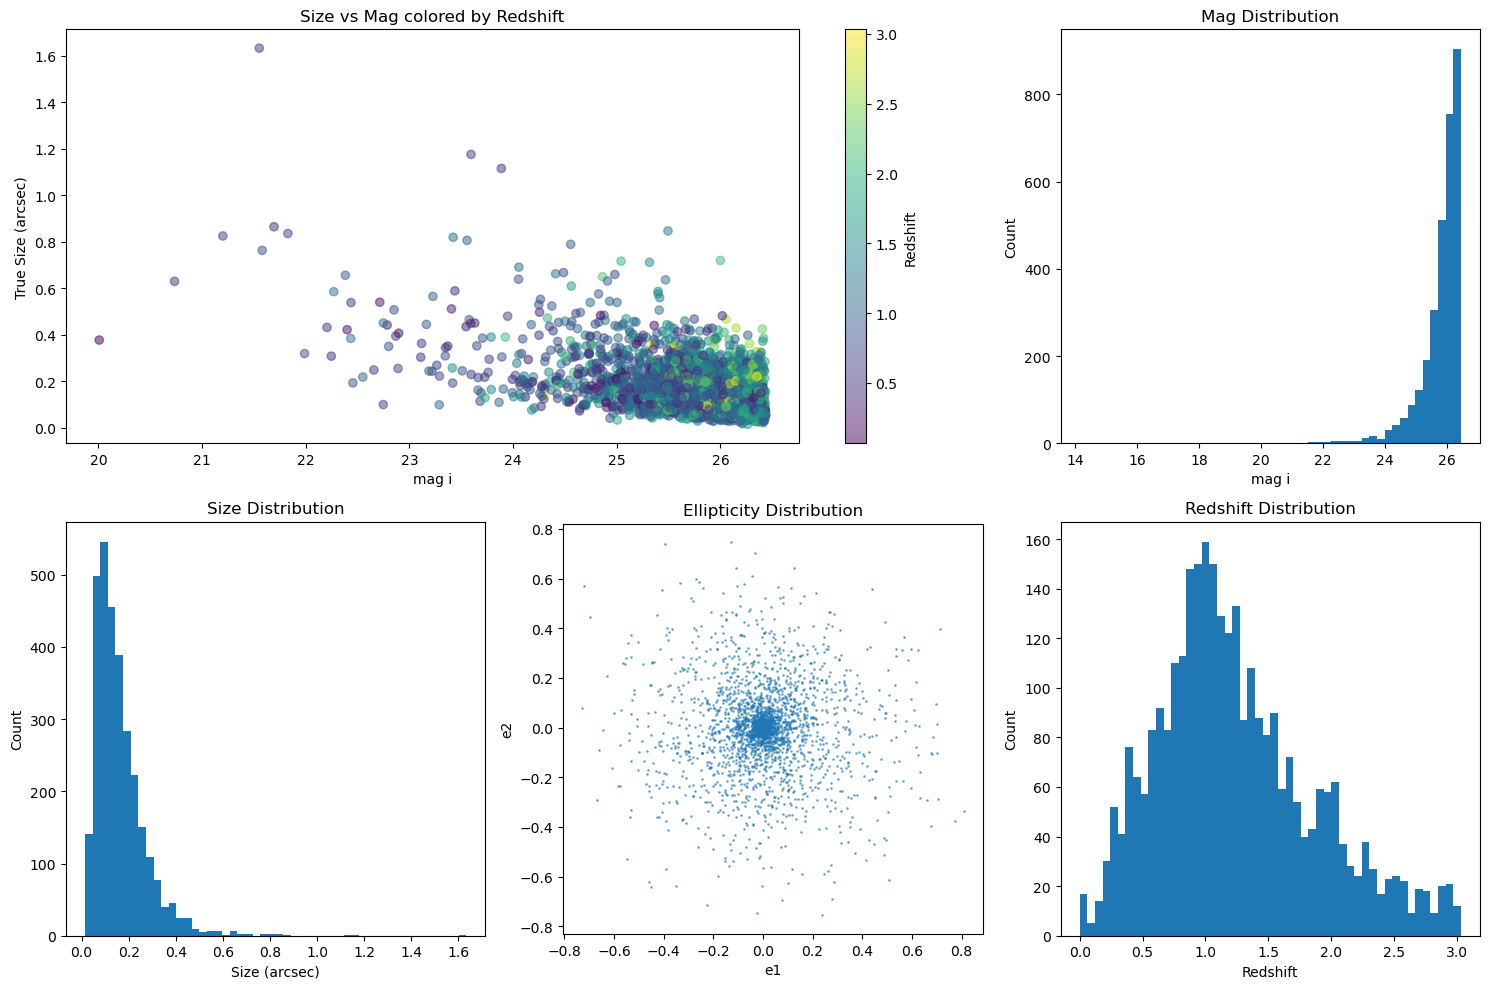

<Figure size 1000x1000 with 0 Axes>

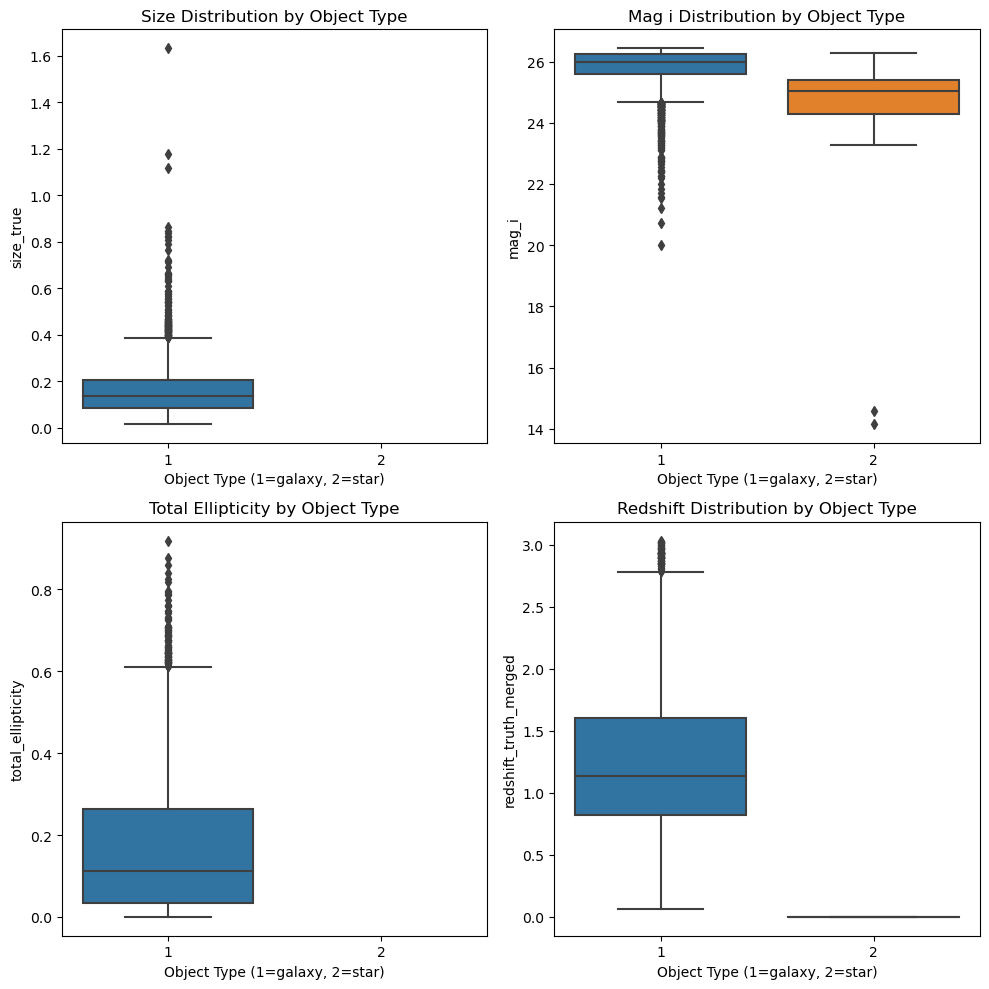

<Figure size 1500x1000 with 0 Axes>

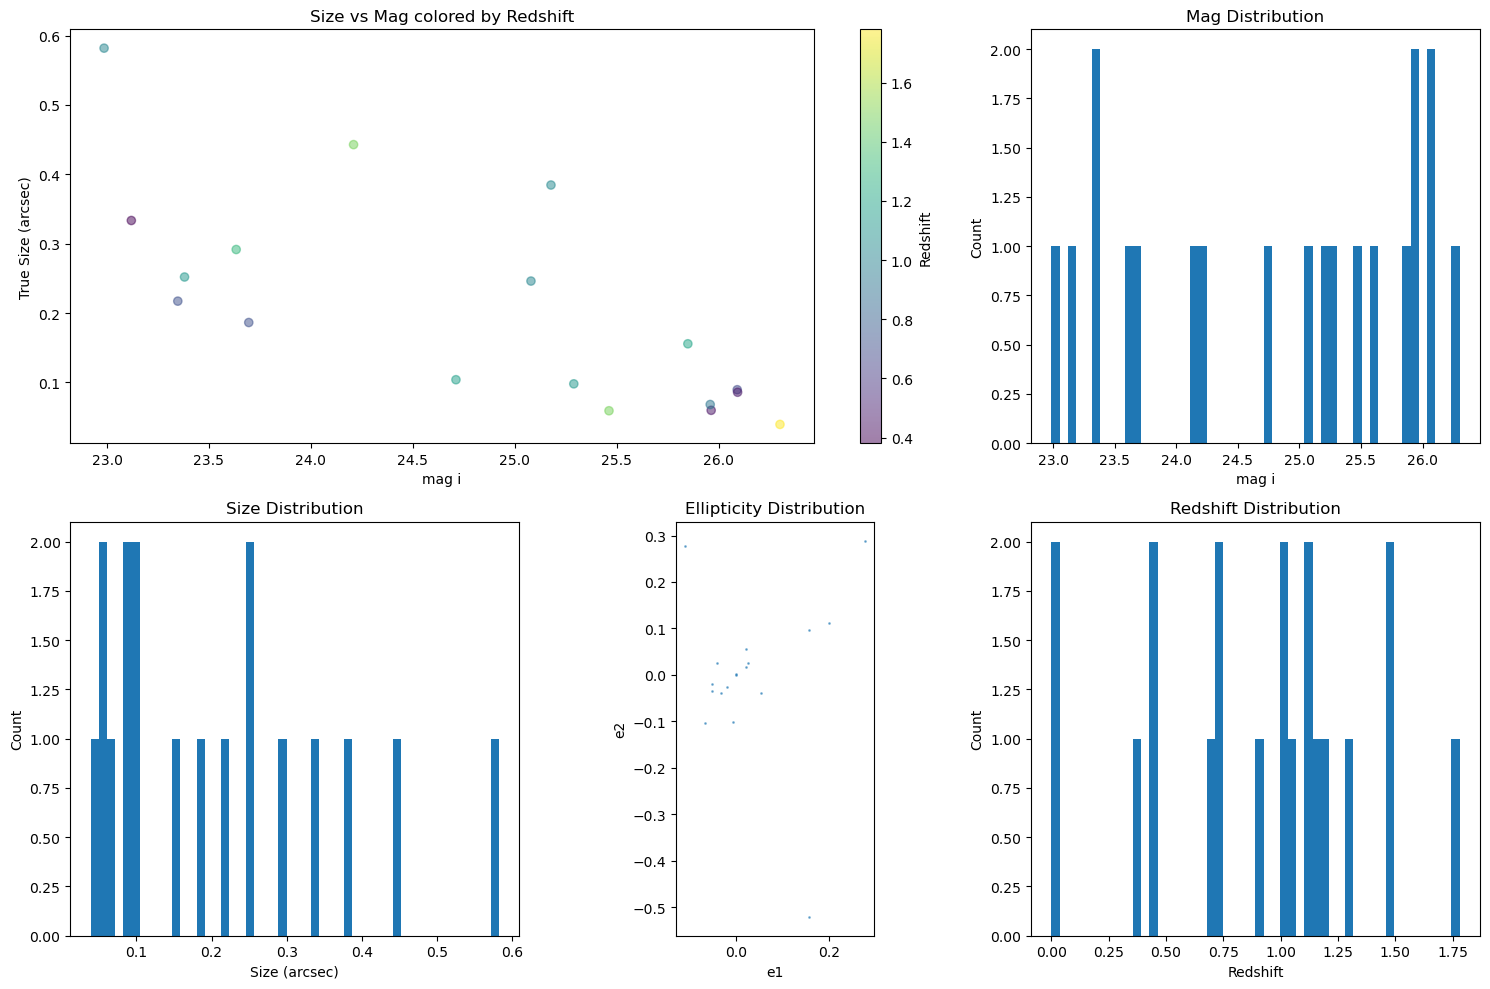

<Figure size 1000x1000 with 0 Axes>

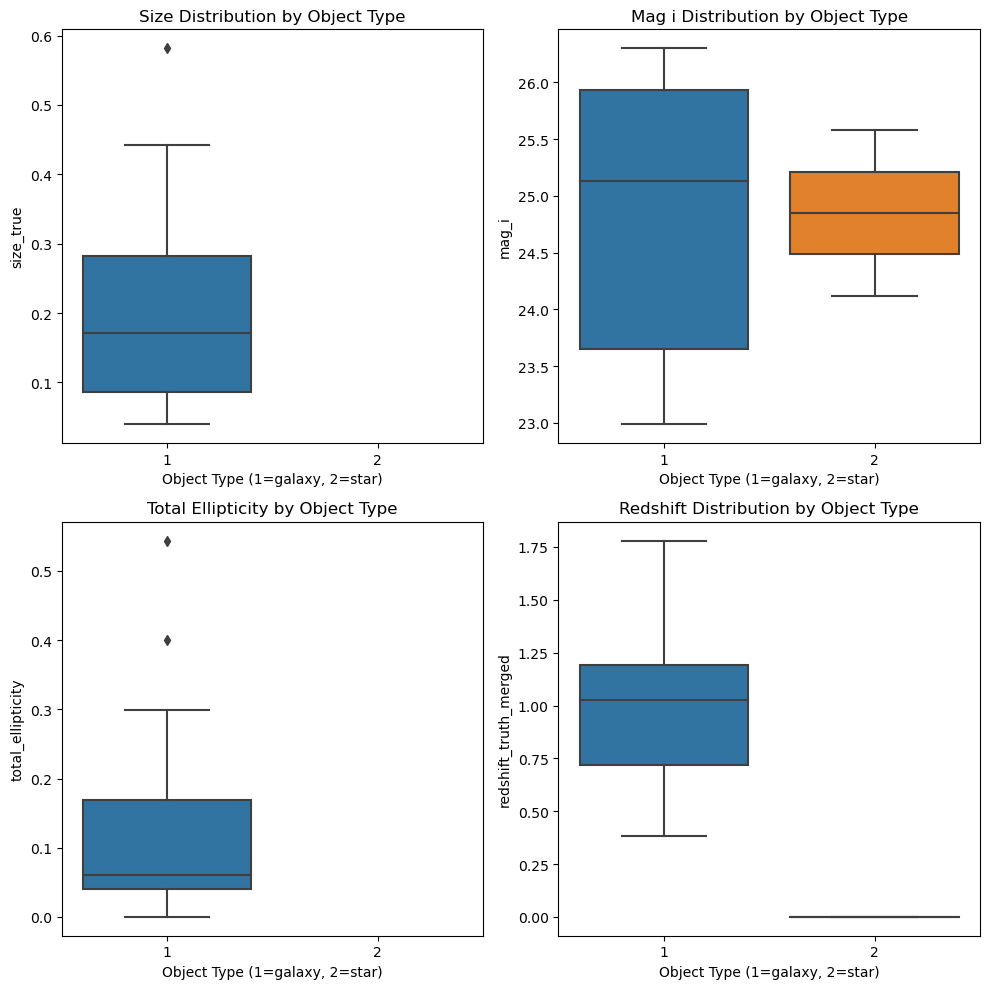

In [119]:
dd_truth_info = pd.read_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_truth11.json', orient='records')

unmatched_objects = analyze_unmatched_objects(dd_det_lsst_det05, dd_truth_info)
unmatched_objects2 = analyze_unmatched_objects2(dd_det_lsst_det05, dd_truth_info)

# unmatched_objects.to_json('/home/yse2/lsst_runs/run4_ups_roman/unmatched_objects.json', orient='records')